In [3]:
from mp_20_utils import load_all_data
datasets_pd, tensors, site_to_ids, element_to_ids, spacegroup_to_ids, max_len = load_all_data()

In [6]:
import torch
from wyckoff_transformer import WyckoffTransformerModel
device='cuda:1'
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 4  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 4  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
n_space_groups = len(spacegroup_to_ids)
# Nope, not all SGs are present
# assert n_space_groups == 230
model = WyckoffTransformerModel(
    n_space_groups = n_space_groups,
    n_sites = len(site_to_ids),
    n_elements = len(element_to_ids),
    d_space_groups = 16,
    d_sites = 64,
    d_species = 64,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout).to(device)
model.load_state_dict(torch.load('checkpoints/2024-01-16_15-31-10/best_model_params.pt'))

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [10]:
def to_combined_dataset(dataset):
    return dict(
        symmetry_sites=torch.stack(dataset['symmetry_sites_tensor'].to_list()).T.to(device),
        symmetry_elements=torch.stack(dataset['symmetry_elements_tensor'].to_list()).T.to(device),
        spacegroup_number=torch.stack(dataset['spacegroup_number_tensor'].to_list()).to(device),
        padding_mask = torch.stack(dataset['padding_mask_tensor'].to_list()).to(device)
    )
torch_datasets = dict(zip(tensors.keys(), map(to_combined_dataset, tensors.values())))
from tokenization import MASK_SITE
MASK_ID_TENSOR=torch.tensor(site_to_ids[MASK_SITE]).to(device)
from torch.nn.functional import softmax
model.eval()
space_groups = torch_datasets["test"]["spacegroup_number"]
sites = torch_datasets["test"]["symmetry_sites"][[0]]
elements = torch_datasets["test"]["symmetry_elements"][[0]]
for i in range(max_len - 1):
    probas_elements = softmax(model(space_groups, sites, elements, None)[0], -1)
    next_elemenets = torch.multinomial(probas_elements[-1], 1).T
    elements = torch.cat((elements, next_elemenets), 0)

    masked_sites = torch.cat([sites, MASK_ID_TENSOR.expand(1, sites.shape[1])], dim=0)
    probas_sites = softmax(model(space_groups, masked_sites, elements, None)[1], -1)
    next_sites = torch.multinomial(probas_sites[-1], 1).T
    sites = torch.cat((sites, next_sites), 0)

In [11]:
idx_to_element = {idx: element for element, idx in element_to_ids.items()}
idx_to_site = {idx: site for site, idx in site_to_ids.items()}
idx_to_spacegroup = {idx: spacegroup for spacegroup, idx in spacegroup_to_ids.items()}

In [13]:
from pymatgen.core import DummySpecie
PAD_ID = site_to_ids["PAD"]
STOP_ID = site_to_ids["STOP"]
ELEMENT_PAD_ID = element_to_ids[DummySpecie()]
ELEMENT_STOP_ID = element_to_ids["STOP"]

In [14]:
generated_structuers = []
for this_elements, this_sites, this_spacegroup in zip(elements.T, sites.T, space_groups):
    sites_str = []
    elements_str = []
    for i in range(len(this_sites)):
      if this_sites[i] in (PAD_ID, STOP_ID) or this_elements[i] in (ELEMENT_PAD_ID, ELEMENT_STOP_ID):
        break
      sites_str.append(idx_to_site[int(this_sites[i])])
      elements_str.append(idx_to_element[int(this_elements[i])])
    generated_structuers.append({
        "spacegroup": int(idx_to_spacegroup[int(this_spacegroup)]),
        "sites": sites_str,
        "elements": elements_str
    })

In [16]:
import pandas as pd
all_datasets = pd.concat(datasets_pd.values())

In [18]:
from collections import defaultdict
from pyxtal.symmetry import Group
index = dict()
wp_index = defaultdict(dict)
from collections import defaultdict
all_sites = defaultdict(set)
for group_number in range(1, 231):
    group = Group(group_number)
    for wp in group.Wyckoff_positions:
        wp.get_site_symmetry()  
        normalised_ss = wp.site_symm.replace(" ", "")
        all_sites[normalised_ss].add(group_number)
        wp_index[group_number][normalised_ss] = (wp.multiplicity, wp.letter)

In [20]:
# Spglib and pyxtal use a different notation for the same space groups
def update_db(site, group):
    if site in wp_index[group] and wp_index[group][site] is None:
        raise KeyError("Site previously not found")
    
    example_records = all_datasets[all_datasets.spacegroup_number == group]
    example_records = example_records[example_records.symmetry_sites.apply(lambda x: site in x)]
    if len(example_records) == 0:
        wp_index[group][site] = None
        raise KeyError("Site previously not found")
    record = example_records.iloc[0]
    example_record = SpacegroupAnalyzer(record["structure"]).get_symmetry_dataset()
    offending_site_index = example_record["site_symmetry_symbols"].index(site)
    offending_site_wp = example_record["wyckoffs"][offending_site_index]

    offending_site_multiplicity = Counter(example_record["crystallographic_orbits"])[
                                            example_record["crystallographic_orbits"][offending_site_index]]
    wp_index[group][site] = (offending_site_multiplicity, offending_site_wp)

In [22]:
import pyxtal
generator = pyxtal.pyxtal()

In [26]:
from collections import Counter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
total = 0
valid = 0
valid_structures = []
for example in generated_structuers:
    total += 1
    T_sites_list = []
    try:
        mutliplicity = []
        for site, element in zip(example['sites'], example['elements']):
            if site not in wp_index[example["spacegroup"]]:
                update_db(site, example["spacegroup"])
            if wp_index[example["spacegroup"]][site] is None:
                raise KeyError("Site not found in the group")
            mutliplicity.append(wp_index[example["spacegroup"]][site][0])
            T_sites_list.append([str(wp_index[example["spacegroup"]][site][0])+wp_index[example["spacegroup"]][site][1]])
        valid += 1
        T_spacegroup = example['spacegroup']
        valid_structures.append({
            "spacegroup": T_spacegroup,
            "sites": T_sites_list,
            "elements": list(map(str, example['elements'])),
            "multiplicity": mutliplicity
        })
    except KeyError:
        #raise
        print(example)
        pass

{'spacegroup': 194, 'sites': ['3m.', '222.', '.3.', '.2/m.', '23.', '1', 'm', '422', 'mmm', '.2/m.', 'm.mm', '-62m', '-3m', '.32', '..2/m'], 'elements': [Element Ga, Element Ne, Element B, Element I, Element Mn, Element Nd, Element Si, Element Sb, Element B, Element S, Element Ti, Element Al, Element Zr, Element Na, Element V]}
{'spacegroup': 160, 'sites': ['3m', '-42.m', '.-3m', '422', '-3m.', '32.', '.2', '422', '.2/m', '-6m2', '-4m2', '3..', '2', '4/mmm', '6/mmm', '-43m', '222.', '2/m', 'm-3.', '222.', 'm2m'], 'elements': [Element Sm, Element Tb, Element Co, Element Hg, Element Nd, Element Be, Element Sb, Element N, Element Pb, Element Nb, Element Ag, Element Bi, Element Na, Element Bi, Element Bi, Element Cr, Element Rh, Element Tc, Element Th, Element Ir, Element Pu]}
{'spacegroup': 65, 'sites': ['mmm', 'm2m.', '4/m..', '-3m.', '3m.', 'm.mm', '-3m', '4..', '222', '.3.', '..m', '-3m', '..m', 'm2m', '-3m.', 'm2m', '2/m', 'MASK_SITE', '.-3.', 'm-3m', '..2/m'], 'elements': [Element Cu

In [27]:
print(valid, total)

401 9046


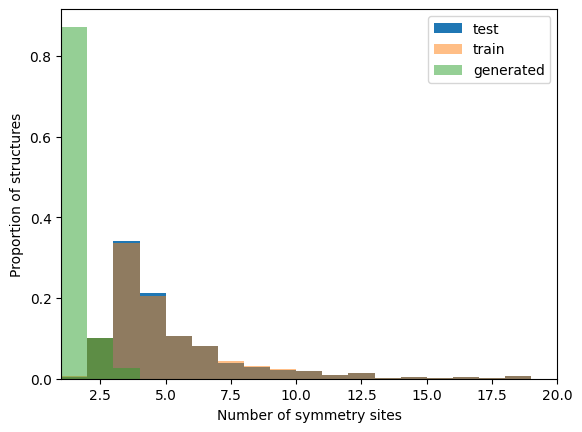

In [29]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = np.arange(1, max_len - 1)
ax.hist(datasets_pd['test'].symmetry_sites.map(len), label="test", density=True, bins=x)
ax.hist(datasets_pd['train'].symmetry_sites.map(len), label="train", density=True, alpha=0.5, bins=x)
ax.hist(list(map(lambda s: len(s["elements"]), valid_structures)), label="generated", density=True, alpha=0.5, bins=x)
ax.set_xlabel("Number of symmetry sites")
ax.set_ylabel("Proportion of structures")
ax.legend()
ax.set_xlim(1, max_len - 1);

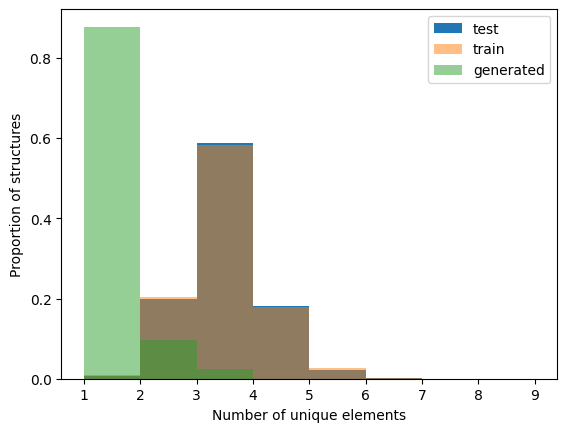

In [31]:
def count_elements(record):
    return len(set(record["elements"]))
def count_elements_pd(record):
    return len(set(record.structure.elements))
fig, ax = plt.subplots()
bins = np.arange(1, 10)
ax.hist(datasets_pd['test'].apply(count_elements_pd, axis=1), label="test", density=True, bins=bins)
ax.hist(datasets_pd['train'].apply(count_elements_pd, axis=1), label="train", density=True, alpha=0.5, bins=bins)
ax.hist(list(map(count_elements, valid_structures)), label="generated", density=True, alpha=0.5, bins=bins)
ax.set_xlabel("Number of unique elements")
ax.set_ylabel("Proportion of structures")
ax.legend();